In [88]:
%reset -f

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("/content/names.txt",'r').read().splitlines()

In [31]:
#words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
# BUILDING THE VOCABULARY MAPPING
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

In [7]:
# BUILDING THE DATASET
# Training (Train parameters), Validation (Hyperparameters), Testing (Evaluate performance) split

block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [29]:
# NEURAL NETWORK

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator = g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator = g) * (5/3)/((n_embd*block_size)**(0.5))
#b1 = torch.randn(n_hidden, generator = g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

'''
Initial values have to be scaled in order to have a forst iteration loss in
the right scale, since the more the logits differ between them, the more
the loss value (initial loss value because then the network learns)
In other words we want an initial equal probability distribution
Also, scale is necessary in order to have a more suitable preactivation
layer so that we get away form the case of dead neurons or neurons that don't
learn (values of tanh are mainly at the extremes -1 and 1)
'''

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C,W1,W2,b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True



12297


In [30]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator = g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass

  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1) # input layer

  hpreact = embcat @ W1 #+ b1 #hidden linear layer preactivation

  # batch normalization layer
  '''
  It has a regularization effect because the function is related to
  all the examples input of the network and not only the batch's ones
  '''
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani)/(bnstdi+0.001) + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.01 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.01 * bnstdi

  # Non-linearity layer
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  lr = 10**-1 if i < 100000 else 10**-2
  for p in parameters:
    p.data += -lr*p.grad

  #tracks
  #if i % 10000 == 0: # print every once in a while
    #print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


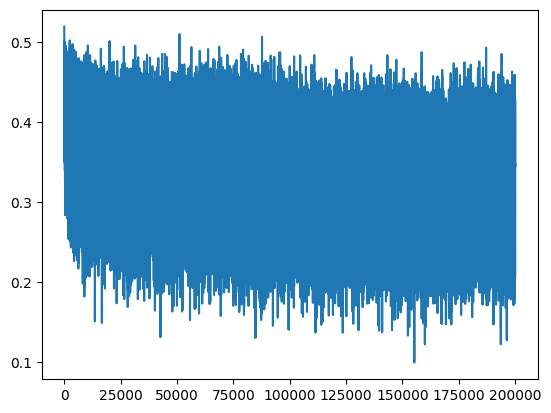

In [31]:
plt.plot(lossi)

In [ ]:
'''Calibrating batch norm at end of training so that it is possible
to forward a single example


with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1

  bnmean = hpreact.mean(0, keepdim = True)
  bnstd = hpreact.std(0, keepdim = True)

'''

In [33]:
# EVALUATE MODEL

@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': {Xtr,Ytr},
      'val': {Xdev, Ydev},
      'test': {Xte,Yte}
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.672881603240967
val 3.673287868499756


In [22]:
# GENERATING FROM THE MODEL

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:

    emb = C[torch.tensor([context])] #(1,block_size,d)
    h = torch.tanh(emb.view(1,-1)@W1 + b1)
    logits = h@W2 + b2
    probs = F.softmax(logits, dim = 1)
    ix = torch.multinomial(probs, num_samples = 1, generator = g). item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
ndhonalarethruthadrie.
cadelynnelin.
shy.
jen.
eden.
edora.
raelynn.
hotha.
noshubergiagriel.
kinde.
jennix.
teron.
ube.
geder.
yarue.
els.
kayshayton.
